In [84]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [98]:
images = 'greendino/greendino/0_startingimages/'
depth = 'greendino/greendino/1_leresdepthmaps/'
masks = 'greendino/greendino/masked/'

In [99]:
i=1
name = os.listdir(images)[i]
img = cv2.imread(images+name)
dpt = cv2.imread(depth+name.replace('.jpg','.png'), cv2.IMREAD_GRAYSCALE)

In [100]:
dpt.min(), dpt.max()

(0, 255)

In [101]:
dpt.shape

(1264, 1264)

114.0


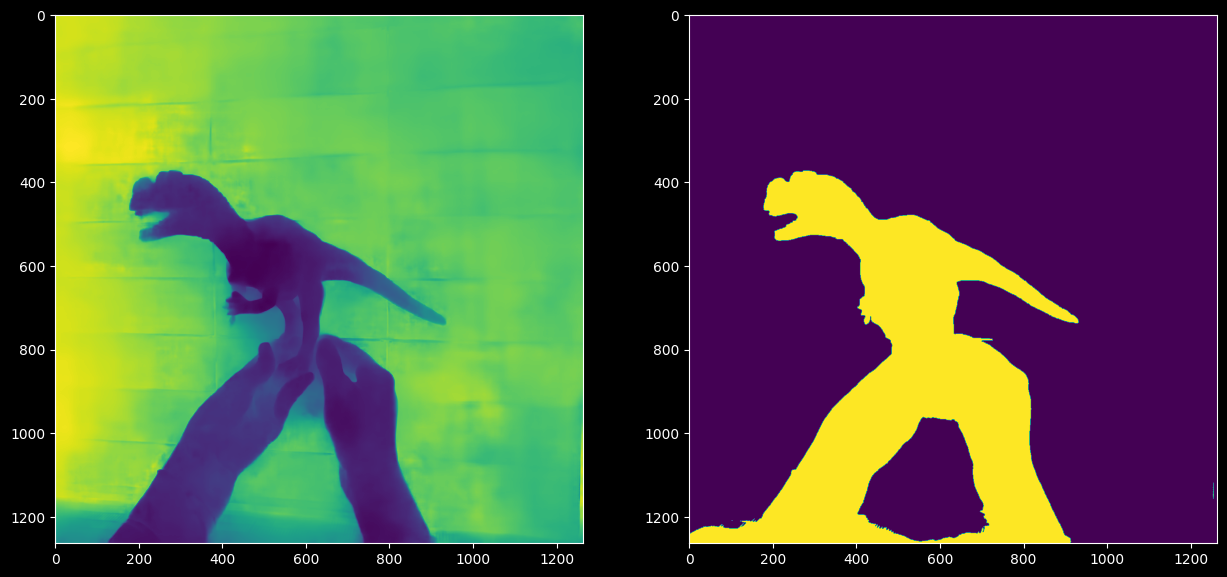

In [102]:
T, _ = cv2.threshold(dpt, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
print(T)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(dpt)
plt.subplot(1,2,2)
plt.imshow(dpt<T+25)

In [103]:
mask=(dpt<(T+25))
mask.shape

(1264, 1264)

(1264, 1264)

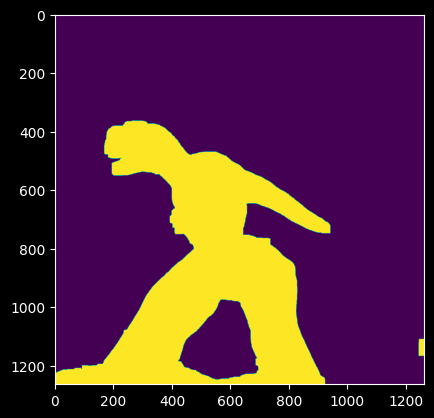

In [104]:
kernel=np.ones((21,21))
d=cv2.dilate(mask*1., kernel, iterations=1).astype(int)
plt.imshow(d)
d.shape

In [105]:
img.shape

(1264, 1264, 3)

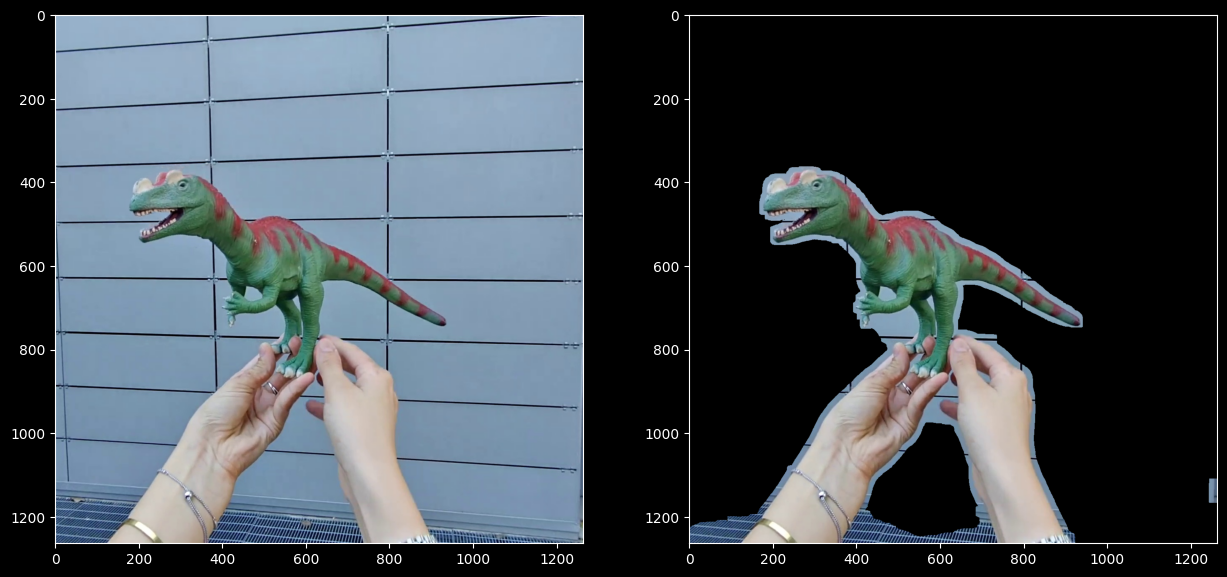

In [106]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img[...,[2,1,0]])
plt.subplot(1,2,2)
plt.imshow(img[...,[2,1,0]]*d[...,None])

In [110]:
C=50
kernel=np.ones((21,21))

for image in os.listdir(images):
    
    img = cv2.imread(images+image)
    dpt = cv2.imread(depth+image.replace('.jpg','.png'), cv2.IMREAD_GRAYSCALE)

    T, _ = cv2.threshold(dpt, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    mask=(dpt<(T+C))
    mask=cv2.dilate(mask*1., kernel, iterations=1).astype(int)

    img = img * mask[:,:,None]
    cv2.imwrite(masks+image+".png", img)
    print(image+".png")

0.jpg.png
1.jpg.png
10.jpg.png
100.jpg.png
101.jpg.png
102.jpg.png
103.jpg.png
104.jpg.png
105.jpg.png
106.jpg.png
107.jpg.png
108.jpg.png
109.jpg.png
11.jpg.png
110.jpg.png
111.jpg.png
112.jpg.png
113.jpg.png
114.jpg.png
115.jpg.png
116.jpg.png
117.jpg.png
118.jpg.png
119.jpg.png
12.jpg.png
120.jpg.png
121.jpg.png
122.jpg.png
123.jpg.png
124.jpg.png
125.jpg.png
126.jpg.png
127.jpg.png
128.jpg.png
129.jpg.png
13.jpg.png
130.jpg.png
131.jpg.png
132.jpg.png
133.jpg.png
134.jpg.png
135.jpg.png
136.jpg.png
137.jpg.png
138.jpg.png
139.jpg.png
14.jpg.png
140.jpg.png
141.jpg.png
142.jpg.png
143.jpg.png
144.jpg.png
145.jpg.png
146.jpg.png
147.jpg.png
148.jpg.png
149.jpg.png
15.jpg.png
150.jpg.png
151.jpg.png
152.jpg.png
153.jpg.png
154.jpg.png
155.jpg.png
156.jpg.png
157.jpg.png
158.jpg.png
159.jpg.png
16.jpg.png
160.jpg.png
161.jpg.png
162.jpg.png
163.jpg.png
164.jpg.png
165.jpg.png
166.jpg.png
167.jpg.png
168.jpg.png
169.jpg.png
17.jpg.png
170.jpg.png
171.jpg.png
172.jpg.png
173.jpg.png
174.